In [79]:
import numpy as np
from scipy.integrate import solve_ivp
from SALib.sample import saltelli, sobol, fast_sampler
from SALib.analyze import sobol, fast
import seaborn as sns
import matplotlib.pyplot as plt
import math
import SALib
from scipy.optimize import fsolve
from scipy.constants import N_A

In [80]:
Target_cell_number = 2e5
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60*100000000
t = np.geomspace(1e-10, t_end, 20)
tspan = [1e-10, t_end]
z0 = [0, 0, 0]
z01 = [0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [81]:
sigma = well_size*N_A/Target_cell_number

def A1_steady_state(x, Ainit, k1, koff, k2, rtot, dummy):
    k1 = k1/sigma
    Atot = sigma*Ainit
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot, dummy):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

problem1 = {
    'num_vars': 5,
    'names': ['rtot', 'kon', 'r_ab', 'koff', 'dummy'],
    'bounds': [[4, 6],
               [4, 6],
               [1e-8, 5e-8],
               [-6, -4],
               [1, 1000]]
}

In [82]:
vals = SALib.sample.sobol.sample(problem1, 65536)
Y_ag1 = np.zeros(len(vals))
Y_ag2 = np.zeros(len(vals))
Y_ab = np.zeros(len(vals))
indicies_ag1 = []
indicies_ag2 = []
indicies_ab = []
A0s = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]

Y = np.zeros(len(vals))
indicies = []
indicies_1 = []

In [83]:
16384*16

262144

In [84]:
for Ainit in A0s:
    print(Ainit)
    for i, params in enumerate(vals):
      
        rtot = params[0]
        rtot = 10**rtot
        kon = params[1]
        kon = 10**kon
        r_ab = params[2]
        koff = params[3]
        koff = 10**koff
        dummy = params[4]

        reaction_volume = (2*1e3*math.pi*(r_ab**3))/3
        target_effective_conc =(rtot)*((math.pi*(r_ab**2))/(tumour_cell_surface_area))*(1/N_A)/(reaction_volume)
        k2 = target_effective_conc*kon/rtot  
        
        if Ainit < 1e-8:
            guess = 0
        else:
            guess = 0

        A1_st = fsolve(A1_steady_state, [guess], args=(Ainit, kon, koff, k2, rtot, dummy))
        A2_st = A2_steady_state(A1_st, k2, koff, rtot, dummy)
        if (A1_st < 0) or (A2_st < 0) :
            print('negative')
        
        if ((A1_st + 2*A2_st) > rtot):
            print('blown up')
        Ag = (A1_st + A2_st)
        Y[i] = Ag
    
    Si = sobol.analyze(problem1, Y, print_to_console=True)
    indicies.append(Si['ST'])
    indicies_1.append(Si['S1'])


1e-11
             ST   ST_conf
rtot   0.778011  0.040342
kon    0.589899  0.034029
r_ab   0.032628  0.002845
koff   0.591750  0.034494
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.144491  0.016781
kon    0.060609  0.013520
r_ab   0.001764  0.001645
koff   0.060924  0.012501
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.188817  0.042556
(rtot, r_ab)   0.006647  0.029395
(rtot, koff)   0.188324  0.042203
(rtot, dummy)  0.001651  0.029039
(kon, r_ab)    0.000596  0.021223
(kon, koff)    0.091289  0.032440
(kon, dummy)  -0.001916  0.020455
(r_ab, koff)   0.002868  0.004469
(r_ab, dummy)  0.000644  0.003392
(koff, dummy) -0.000359  0.020364
1e-10
             ST   ST_conf
rtot   0.999084  0.007918
kon    0.001339  0.000072
r_ab   0.000072  0.000005
koff   0.001338  0.000076
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.998014  0.008774
kon    0.000276  0.000355
r_ab   0.000010  0.000077
koff   0.000268  0.000367
dummy  0.000000 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST       ST_conf
rtot   0.999978  7.796387e-03
kon    0.000040  2.947245e-06
r_ab   0.000003  3.317788e-07
koff   0.000040  2.870386e-06
dummy  0.000000  0.000000e+00
                 S1   S1_conf
rtot   9.999470e-01  0.011943
kon    8.031926e-06  0.000068
r_ab  -4.708154e-08  0.000017
koff   8.331584e-06  0.000071
dummy  0.000000e+00  0.000000
                     S2   S2_conf
(rtot, kon)    0.000006  0.018182
(rtot, r_ab)  -0.000004  0.018186
(rtot, koff)   0.000007  0.018184
(rtot, dummy) -0.000005  0.018191
(kon, r_ab)    0.000004  0.000100
(kon, koff)    0.000014  0.000100
(kon, dummy)   0.000004  0.000100
(r_ab, koff)   0.000002  0.000022
(r_ab, dummy)  0.000002  0.000022
(koff, dummy) -0.000035  0.000114
1e-08


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST       ST_conf
rtot   0.999983  8.596867e-03
kon    0.000001  5.830780e-08
r_ab   0.000023  3.921400e-07
koff   0.000001  6.628681e-08
dummy  0.000000  0.000000e+00
                 S1   S1_conf
rtot   9.999761e-01  0.013318
kon    4.772906e-07  0.000011
r_ab   1.562859e-05  0.000051
koff   3.309784e-07  0.000012
dummy  0.000000e+00  0.000000
                         S2   S2_conf
(rtot, kon)   -7.190094e-08  0.018596
(rtot, r_ab)   6.885558e-06  0.018592
(rtot, koff)   6.568153e-08  0.018596
(rtot, dummy)  8.586362e-09  0.018596
(kon, r_ab)    1.508805e-07  0.000016
(kon, koff)    5.782271e-07  0.000016
(kon, dummy)   1.353601e-07  0.000016
(r_ab, koff)   4.308363e-07  0.000069
(r_ab, dummy)  4.202039e-07  0.000069
(koff, dummy)  2.060772e-09  0.000018
1e-07


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
rtot   9.998584e-01  7.841153e-03
kon    1.043460e-07  4.868516e-09
r_ab   2.116574e-04  3.912436e-06
koff   1.042298e-07  5.043611e-09
dummy  0.000000e+00  0.000000e+00
                 S1   S1_conf
rtot   9.997883e-01  0.012095
kon    7.437252e-08  0.000003
r_ab   1.414863e-04  0.000153
koff   2.850883e-08  0.000004
dummy  0.000000e+00  0.000000
                         S2   S2_conf
(rtot, kon)   -8.281672e-08  0.018825
(rtot, r_ab)   7.014671e-05  0.018828
(rtot, koff)  -4.365398e-08  0.018827
(rtot, dummy) -3.336975e-08  0.018826
(kon, r_ab)    4.041614e-08  0.000005
(kon, koff)    7.913102e-08  0.000005
(kon, dummy)   3.873891e-08  0.000005
(r_ab, koff)   7.498436e-08  0.000251
(r_ab, dummy)  7.588618e-08  0.000251
(koff, dummy)  8.846028e-10  0.000005
1e-06


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
rtot   9.992148e-01  7.773062e-03
kon    8.634453e-09  4.263295e-10
r_ab   1.334076e-03  2.409585e-05
koff   8.624724e-09  4.214304e-10
dummy  0.000000e+00  0.000000e+00
                 S1       S1_conf
rtot   9.986660e-01  1.105625e-02
kon    1.446911e-08  1.068529e-06
r_ab   7.852400e-04  4.379942e-04
koff   3.377129e-09  9.691495e-07
dummy  0.000000e+00  0.000000e+00
                         S2   S2_conf
(rtot, kon)   -1.439221e-07  0.018887
(rtot, r_ab)   5.487290e-04  0.018872
(rtot, koff)  -1.376909e-07  0.018887
(rtot, dummy) -1.317495e-07  0.018887
(kon, r_ab)    1.203278e-08  0.000002
(kon, koff)    1.502960e-08  0.000002
(kon, dummy)   1.174726e-08  0.000002
(r_ab, koff)  -1.036978e-07  0.000674
(r_ab, dummy) -1.019347e-07  0.000674
(koff, dummy) -1.335028e-09  0.000001
1e-05
                 ST       ST_conf
rtot   9.983270e-01  8.252637e-03
kon    5.089891e-10  2.493332e-11
r_ab   3.767498e-03  6.786602e-05
koff   5.083608e-10  2.946414e-1

7


/var/folders/fj/3c6fc0c93lg7p91tnylb8zj80000gn/T/ipykernel_37115/2877542889.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Dark2')


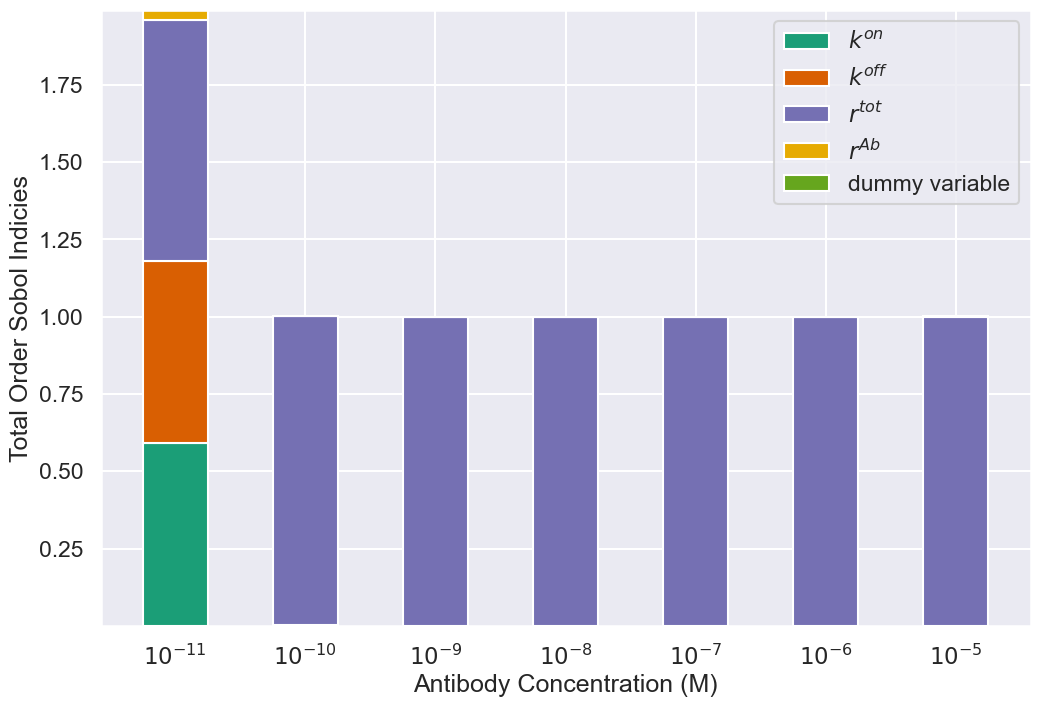

In [85]:

kon_si = np.zeros(len(A0s))
koff_si = np.zeros(len(A0s))
rab_si = np.zeros(len(A0s))
rtot_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))


for i in range(len(indicies)):
    vals = indicies[i]
    rtot_si[i] = vals[0]
    kon_si[i] = vals[1]
    rab_si[i] = vals[2]
    koff_si[i] = vals[3]
    dummy_si[i] = vals[4]

print(len(indicies))
ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')


sns.set_theme()
sns.set_context("talk")

width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(7)

cm = plt.cm.get_cmap('Dark2')
ax.bar(ab_conc, kon_si, width, label=r'$k^{on}$', bottom= bottom, color=cm(0))
bottom+= kon_si
ax.bar(ab_conc, koff_si, width, label=r'$k^{off}$', bottom= bottom, color=cm(1))
bottom+= koff_si
ax.bar(ab_conc, rtot_si, width, label=r'$r^{tot}$', bottom= bottom, color=cm(2))
bottom+= rtot_si
ax.bar(ab_conc, rab_si, width, label=r'$r^{Ab}$', bottom= bottom, color=cm(5))
bottom+= rab_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color=cm(4))
ax.legend(loc='best')
ax.set_xlabel('Antibody Concentration (M)')
ax.set_ylabel('Total Order Sobol Indicies')
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_r_bound_antibody_total_order_sensiv_analysis.png')

In [86]:
3*1e6/(8*N_A*1e3*1e-15)

6.227021501901925e-07